[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

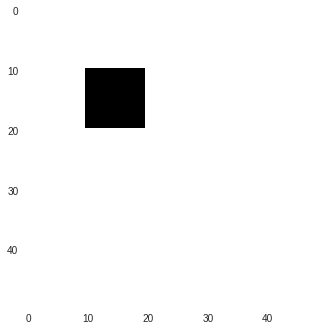

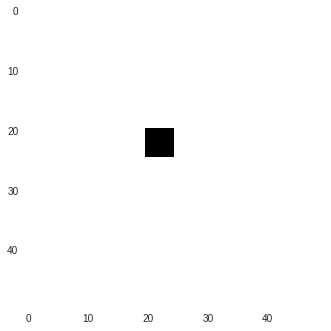

[(20, 20), (20, 21), (20, 22), (20, 23), (20, 24)]

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# initial coordinates for agents
L = 10
scaling_factor = 5
gridshape = (scaling_factor*L,scaling_factor*L)
grid = np.zeros(gridshape)
grid[L:2*L,L:2*L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

# make shape
shape = np.zeros(gridshape)

#shape[:L,:L] = 1

#shape[L-5:L,L-5:L] = 1
shape[2*L:2*L+5,2*L:2*L+5] = 1

#shape[L:-3,L:-3] = 1
#shape[int(1.25*L):-3,int(1.25*L):-3] = 0 

plt.imshow(shape)
plt.grid(False)
plt.show()

shape_coordinates = []
for x in range(shape.shape[0]):
  for y in range(shape.shape[1]):
    if shape[x,y] == 1:
      shape_coordinates.append((x,y))
shape_coordinates[:5]

In [44]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = []

for x in range(gridshape[0]):
  for y in range(gridshape[1]):
    if grid[x,y]==1:
      agents.append({'true_coordinates':(x,y),
                     'estimated_coordinates':(x,y),
                     'orientation':(-1,0),
                     'id':len(agents),
                     'is_source':bool((x,y)==(2*L-1,2*L-1))
                    })

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))
  #return abs(a[0]-b[0])+abs(a[1]-b[1])

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_distances_estimations(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  estimated_coordinates = agent['estimated_coordinates']
  
  if len(neighbors)>0:
  
    neighbors_estimated_coordinates = [agents[n]['estimated_coordinates'] for n in neighbors]
    # DEBUG: print 'neighbors for agent id ',agent['id'],' at ',center,'are: ',neighbors
    def error_estimated_coordinates(xy):
      discrepancies = [d - distance_metric(xy,neighbors_estimated_coordinates[i]) for i,d in enumerate(distances)]
      return sum([abs(d) for d in discrepancies])

    neighbors_estimated_coordinates_x = [c[0] for c in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [c[1] for c in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x,max_x+1),range(min_y,max_y+1)))
    candidate_estimation_errors = [error_estimated_coordinates(xy) for xy in candidate_estimations]

    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
  
  return [neighbors,distances,estimated_coordinates]


for a in agents:
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

In [45]:
# initialize gradient values.

for a in agents:
  if a['is_source']:
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'gradient_value': 9,
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

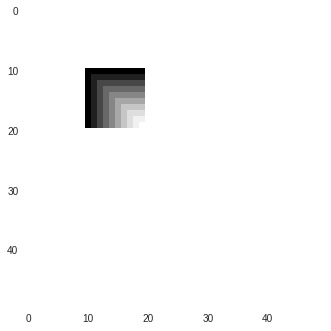

In [46]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [0]:
# edge-following
def leaves_shape(old_loc,new_loc):
  ans = False
  if old_loc in shape_coordinates:
    if new_loc not in shape_coordinates:
      ans = True
  return ans
  
def can_move(a,debug=False):
  neighbors = a['neighbors']
  (x0,y0) = a['true_coordinates']
  (dx,dy) = a['orientation']
  (x,y) = (x0+dx,y0+dy)

  ans = False
  occupied = [agents[neighbors[i]]['true_coordinates'] for i,d in enumerate(a['distances']) if d==1]
  if (x,y) not in occupied:
    if x in range(gridshape[0]) and y in range(gridshape[1]): # in grid
      if not leaves_shape((x0,y0),(x,y)): # doesn't leave shape
        needs_a_neighbor = [point for point in [(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x-1,y-1),(x-1,y+1),(x+1,y-1),(x+1,y+1)] if point != (x0,y0)]
        if any([(point in occupied) for point in needs_a_neighbor]): # doesn't isolate itself
          ans = True
          if debug:
            ans = [(x0,y0), (dx,dy), (x,y)]
  return ans

def update(a):
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)

def timestep(first_attempt_agent_index=0,agents=agents,shape_coordinates=shape_coordinates):
  
  if can_move(agents[first_attempt_agent_index]):
    selected_agent_index = first_attempt_agent_index
  else:
    movable_agents_not_in_shape = [i for i,a in enumerate(agents) if can_move(a) and a['estimated_coordinates'] not in shape_coordinates]
    selected_agent_index = random.choice(movable_agents_not_in_shape)
  
  selected_agent = agents[selected_agent_index]
  
  highlight_list = ['loc before move: '+str(selected_agent['true_coordinates'])]
  highlight_list = ['orientation before move: '+str(selected_agent['orientation'])]
  
  # move
  (x0,y0) = selected_agent['true_coordinates']
  (dx,dy) = selected_agent['orientation']
  selected_agent['true_coordinates'] = (x0+dx,y0+dy)
  
  highlight_list = highlight_list + ['loc after move: '+str(selected_agent['true_coordinates'])]
  
  old_neighbors = selected_agent['neighbors']
  update(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  highlight_list = highlight_list + ['loc after update: '+str(selected_agent['true_coordinates'])]
  
  move_tries = 0
  turn_sequence = [(turnx,turny) for (turnx,turny) in [(-1,0),(0,1),(1,0),(0,-1)] if (turnx+dx,turny+dy) != (0,0)]
  i = turn_sequence.index(selected_agent['orientation'])
  turn_sequence = [turn_sequence[(i+1)%3],turn_sequence[(i+2)%3],turn_sequence[i]]
    
  num_turns = 0
  while not can_move(selected_agent):
    selected_agent['orientation'] = turn_sequence[num_turns]
    num_turns += 1
    if num_turns == 3:
      break
     
  highlight_list = highlight_list + ['loc after turn: '+str(selected_agent['true_coordinates'])]
  highlight_list = highlight_list + ['orientation after turn: '+str(selected_agent['orientation'])]
  
  for i in list(set(old_neighbors).union(set(new_neighbors))):
    update(agents[i]) 
    
  debug_list = highlight_list + ['loc after neighbor updates: '+str(selected_agent['true_coordinates'])]
    
  return selected_agent_index, debug_list

def plot_grid(highlight_list=[]):
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
    
  for coordinates in highlight_list:
    grid[coordinates[0],coordinates[1]]=2
    
  plt.imshow(grid)
  plt.grid(False)
  plt.show()
  

t=0
['orientation before move: (1, 0)', 'loc after move: (14, 20)', 'loc after update: (14, 20)', 'loc after turn: (14, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (14, 20)']


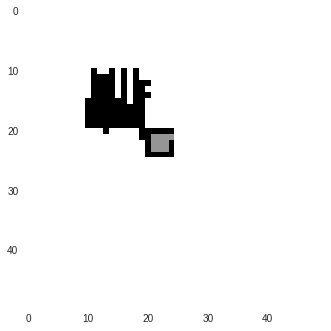

t=1
['orientation before move: (1, 0)', 'loc after move: (15, 20)', 'loc after update: (15, 20)', 'loc after turn: (15, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (15, 20)']


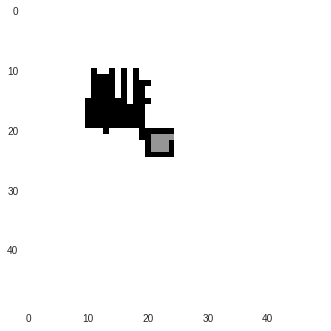

t=2
['orientation before move: (1, 0)', 'loc after move: (16, 20)', 'loc after update: (16, 20)', 'loc after turn: (16, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (16, 20)']


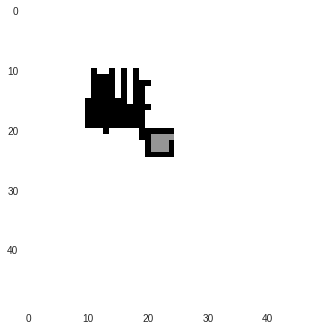

t=3
['orientation before move: (1, 0)', 'loc after move: (17, 20)', 'loc after update: (17, 20)', 'loc after turn: (17, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (17, 20)']


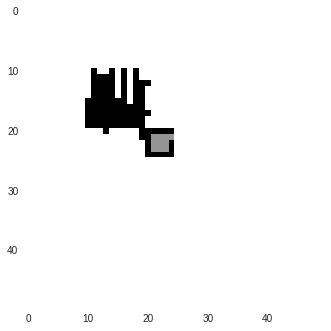

t=4
['orientation before move: (1, 0)', 'loc after move: (18, 20)', 'loc after update: (18, 20)', 'loc after turn: (18, 20)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (18, 20)']


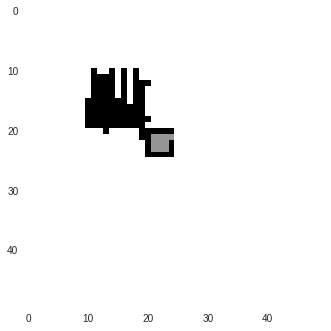

t=5
['orientation before move: (1, 0)', 'loc after move: (19, 20)', 'loc after update: (19, 20)', 'loc after turn: (19, 20)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (19, 20)']


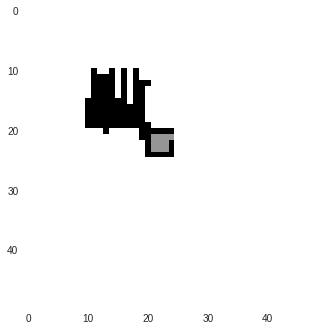

t=6
['orientation before move: (0, 1)', 'loc after move: (19, 21)', 'loc after update: (19, 21)', 'loc after turn: (19, 21)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (19, 21)']


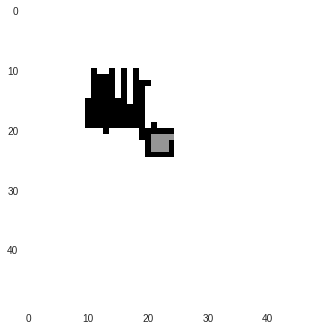

t=7
['orientation before move: (0, 1)', 'loc after move: (19, 22)', 'loc after update: (19, 22)', 'loc after turn: (19, 22)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (19, 22)']


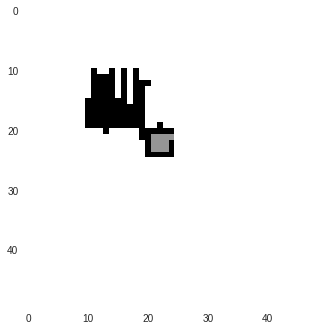

t=8
['orientation before move: (0, 1)', 'loc after move: (19, 23)', 'loc after update: (19, 23)', 'loc after turn: (19, 23)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (19, 23)']


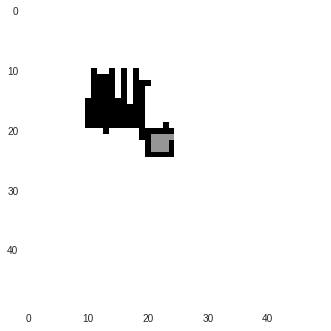

t=9
['orientation before move: (0, 1)', 'loc after move: (19, 24)', 'loc after update: (19, 24)', 'loc after turn: (19, 24)', 'orientation after turn: (0, 1)', 'loc after neighbor updates: (19, 24)']


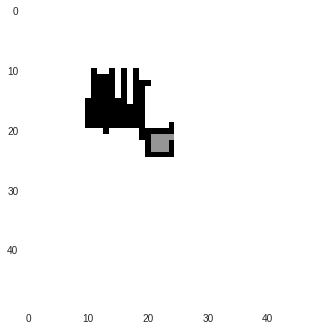

t=10
['orientation before move: (0, 1)', 'loc after move: (19, 25)', 'loc after update: (19, 25)', 'loc after turn: (19, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (19, 25)']


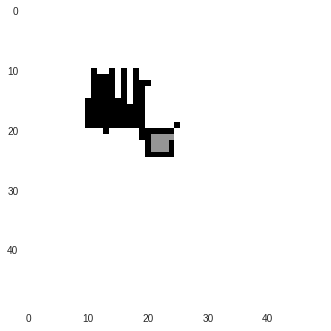

t=11
['orientation before move: (1, 0)', 'loc after move: (20, 25)', 'loc after update: (20, 25)', 'loc after turn: (20, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (20, 25)']


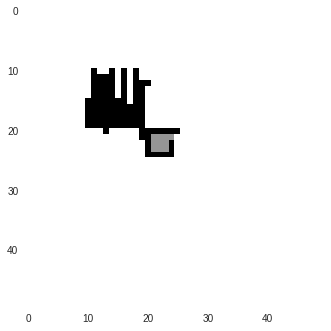

t=12
['orientation before move: (1, 0)', 'loc after move: (21, 25)', 'loc after update: (21, 25)', 'loc after turn: (21, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (21, 25)']


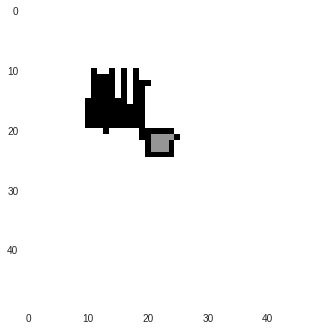

t=13
['orientation before move: (1, 0)', 'loc after move: (22, 25)', 'loc after update: (22, 25)', 'loc after turn: (22, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (22, 25)']


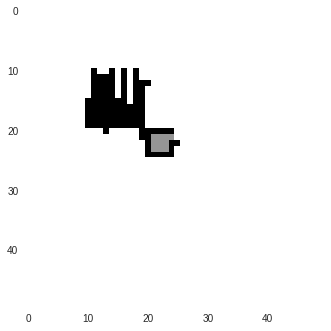

t=14
['orientation before move: (1, 0)', 'loc after move: (23, 25)', 'loc after update: (23, 25)', 'loc after turn: (23, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (23, 25)']


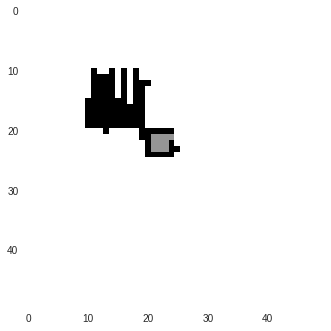

t=15
['orientation before move: (1, 0)', 'loc after move: (24, 25)', 'loc after update: (24, 25)', 'loc after turn: (24, 25)', 'orientation after turn: (1, 0)', 'loc after neighbor updates: (24, 25)']


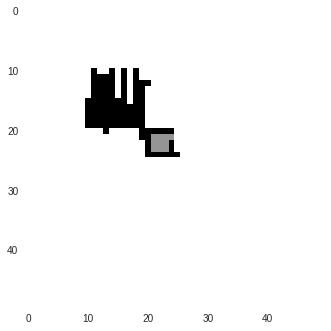

t=16
['orientation before move: (1, 0)', 'loc after move: (25, 25)', 'loc after update: (25, 25)', 'loc after turn: (25, 25)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (25, 25)']


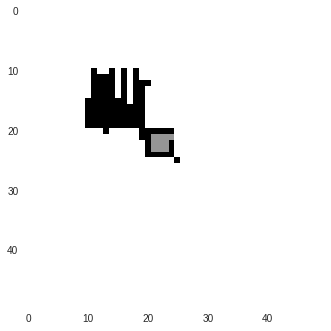

t=17
['orientation before move: (0, -1)', 'loc after move: (25, 24)', 'loc after update: (25, 24)', 'loc after turn: (25, 24)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (25, 24)']


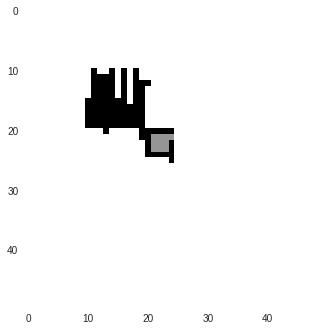

t=18
['orientation before move: (0, -1)', 'loc after move: (25, 23)', 'loc after update: (25, 23)', 'loc after turn: (25, 23)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (25, 23)']


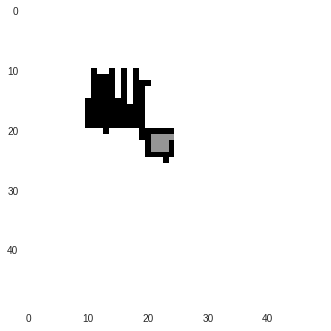

t=19
['orientation before move: (0, -1)', 'loc after move: (25, 22)', 'loc after update: (25, 22)', 'loc after turn: (25, 22)', 'orientation after turn: (0, -1)', 'loc after neighbor updates: (25, 22)']


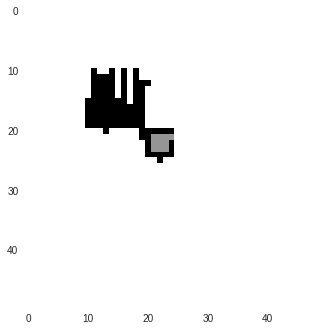

In [57]:
#selected_agent_index = 0
for t in range(20):
  selected_agent_index, debug_list = timestep(selected_agent_index)
  if t%1==0:
    print 't='+str(t)
    print debug_list
    plot_grid()